In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
layer_size_list = [2,10,1]
np.random.seed(50)
weight_list = [np.random.normal(0,0.1,(layer_size_list[x]+1,layer_size_list[x+1])) for x in range(len(layer_size_list)-1)]
#weight_list = [np.array([[0.1,0.2],[0.3,0.4]]),np.array([[0.2],[1],[-3]]),np.array([[1],[2]])]
no_of_layers = 3
path = 'D:\Courses\Fall 19\ELEG 815 Statistical Learning\HW6\Dataset'
train_data_all = pd.read_csv(path+'\DigitsTraining.csv',header=None)
test_data_all = pd.read_csv(path+'\DigitsTesting.csv',header=None)
train_data = train_data_all.sample(n=500)
test_data = test_data_all.sample(n=500)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)
train_labels = train_data[0]

In [19]:
train_data = train_data.drop([0],axis=1)
print(train_data.shape)

(500, 256)


In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def identity(z):
    return z
def feedforward(datapoint,weight_list):
    prev_layer_activations = datapoint
    signal_list = [0]*(no_of_layers-1)
    activations_list = [0]*no_of_layers
    activations_list[0] = datapoint
    for layer in range(1,no_of_layers):     # l= 2 to L
        WX = np.dot(weight_list[layer-1].T,prev_layer_activations)   
        Z = WX
        signal_list[layer-1] = Z
        if layer == 2:
            activation_Z = identity(Z)
        else:
            activation_Z = tanh(Z)
        x_n = np.empty((activation_Z.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = activation_Z
        activations_list[layer] = x_n
        prev_layer_activations = x_n
    return signal_list,activations_list

In [4]:
def backprop(x,y):
    x_n = np.empty((x.shape[0]+1,))
    x_n[0] = 1
    x_n[1:] = x
    s_l,x_l = feedforward(x_n,weight_list)
    delta_L_tanh = 2 * (x_l[-1][1:] - y) * (1 - x_l[-1][1:]*x_l[-1][1:])
    delta_L_identity = 2 * (x_l[-1][1:] - y)
    deltas_list = [0]*(no_of_layers-1)
    deltas_list[-1] = delta_L_identity
    upstream_gradient = delta_L_identity
    for l in range(no_of_layers-2,0,-1):
        theta_dash_s_l = 1 - x_l[l][1:]*x_l[l][1:]
        delta_l = theta_dash_s_l * np.dot(weight_list[l][1:],upstream_gradient)
        upstream_gradient = delta_l
        deltas_list[l-1] = delta_l
    return deltas_list,x_l

In [5]:
def Extract_features(raw_dataset):
    len_dataset = len(raw_dataset)
    number_of_features = 2
    dataset = np.empty((len_dataset,number_of_features))
    true_labels = np.empty((len_dataset,))
    for index,image_pixels in raw_dataset.iterrows():
        """---------------------- Average Intensity-------------------------"""
        avg_intensity = sum(image_pixels[1:])/len(image_pixels[1:])

        """-----------------------Average Symmetry--------------------------"""
        img = np.array(image_pixels[1:]).reshape((16,16))
        flipped_image = np.fliplr(img)
        flipped_image_pixels = flipped_image.flatten()
        image_pixels = np.array(image_pixels)
        asymmetry = sum(np.absolute(image_pixels[1:] - flipped_image_pixels))/len(image_pixels[1:])
        symmetry = 1 - asymmetry
        dataset[index][0] = 1 - avg_intensity           # Higher value of intensity means there are more white pixels than black pixels because white = 255 and black = 0
        dataset[index][1] = symmetry
        if int(image_pixels[0]) == 1:                   # Suppose digit 1 has label = -1
            true_labels[index] = -1
        else:
            true_labels[index] = 1                      # Suppose all other digits have label = +1
    return dataset,true_labels
d_2_train_dataset,d_2_train_labels = Extract_features(train_data)
d_2_test_dataset,d_2_test_labels = Extract_features(test_data)

In [6]:
print(d_2_test_dataset.shape)
print(weight_list[1])

(500, 2)
[[ 0.10952095]
 [ 0.13384087]
 [-0.13689817]
 [ 0.04864276]
 [ 0.07535217]
 [ 0.03634646]
 [-0.03147105]
 [ 0.13732812]
 [-0.06244172]
 [ 0.0375754 ]
 [-0.02004163]]


In [7]:
def GD(weight_list,d_2_train_dataset,d_2_train_labels,learning_rate):
    w = weight_list
    D = d_2_train_dataset
    N = len(D)
    y = d_2_train_labels
    E_in = 0
    g = [0] * (no_of_layers-1)
    for index,d in enumerate(D):
        deltas_list,x_l = backprop(d,y[index])
        E_in += (1/N) * (x_l[-1][1] - y[index])**2
        for l in range(1,no_of_layers):
            delta = deltas_list[l-1].reshape((deltas_list[l-1].shape[0],1))
            x_l_previos = x_l[l-1].reshape((x_l[l-1].shape[0],1)) 
            G_l_xn = np.dot(x_l_previos,delta.T)
            g[l-1] += (1/N) * G_l_xn
    print('E_in :',E_in)
    for l in range(1,no_of_layers):
        weight_list[l-1] -= learning_rate * g[l-1]
    return E_in,weight_list

In [8]:
def train_GD(epochs):
    errors = [0] * epochs
    for epoch in range(epochs):
        print('Epoch :',epoch)
        errors[epoch],weights = GD(weight_list,d_2_train_dataset,d_2_train_labels,0.01)
    return errors,weight_list
errors_GD,weight_list_new_GD = train_GD(10000)

Epoch : 0
E_in : 0.9357627380609963
Epoch : 1
E_in : 0.9148684600770909
Epoch : 2
E_in : 0.8951103996350039
Epoch : 3
E_in : 0.8764177146705475
Epoch : 4
E_in : 0.8587250010668385
Epoch : 5
E_in : 0.8419717710733986
Epoch : 6
E_in : 0.8261019916250237
Epoch : 7
E_in : 0.8110636747018124
Epoch : 8
E_in : 0.7968085130173903
Epoch : 9
E_in : 0.7832915552852292
Epoch : 10
E_in : 0.7704709161247492
Epoch : 11
E_in : 0.7583075163549803
Epoch : 12
E_in : 0.7467648500054284
Epoch : 13
E_in : 0.7358087748681739
Epoch : 14
E_in : 0.7254073238367031
Epoch : 15
E_in : 0.715530534637097
Epoch : 16
E_in : 0.7061502958655336
Epoch : 17
E_in : 0.6972402075109788
Epoch : 18
E_in : 0.688775454369732
Epoch : 19
E_in : 0.6807326909551535
Epoch : 20
E_in : 0.6730899366757453
Epoch : 21
E_in : 0.6658264802020236
Epoch : 22
E_in : 0.6589227920703918
Epoch : 23
E_in : 0.6523604446833475
Epoch : 24
E_in : 0.6461220389623021
Epoch : 25
E_in : 0.6401911369938497
Epoch : 26
E_in : 0.6345522000843506
Epoch : 27
E_

E_in : 0.5233508200485962
Epoch : 227
E_in : 0.5233352658767583
Epoch : 228
E_in : 0.5233197058104049
Epoch : 229
E_in : 0.5233041393732584
Epoch : 230
E_in : 0.5232885661108442
Epoch : 231
E_in : 0.5232729855893705
Epoch : 232
E_in : 0.5232573973946539
Epoch : 233
E_in : 0.523241801131111
Epoch : 234
E_in : 0.5232261964207895
Epoch : 235
E_in : 0.5232105829024644
Epoch : 236
E_in : 0.5231949602307625
Epoch : 237
E_in : 0.5231793280753523
Epoch : 238
E_in : 0.5231636861201581
Epoch : 239
E_in : 0.5231480340626219
Epoch : 240
E_in : 0.5231323716130092
Epoch : 241
E_in : 0.5231166984937361
Epoch : 242
E_in : 0.5231010144387458
Epoch : 243
E_in : 0.5230853191929078
Epoch : 244
E_in : 0.5230696125114535
Epoch : 245
E_in : 0.5230538941594355
Epoch : 246
E_in : 0.5230381639112179
Epoch : 247
E_in : 0.5230224215499977
Epoch : 248
E_in : 0.5230066668673397
Epoch : 249
E_in : 0.5229908996627456
Epoch : 250
E_in : 0.5229751197432397
Epoch : 251
E_in : 0.5229593269229773
Epoch : 252
E_in : 0.5229

E_in : 0.5194243525426827
Epoch : 452
E_in : 0.5194043608981279
Epoch : 453
E_in : 0.5193843420538216
Epoch : 454
E_in : 0.5193642959468333
Epoch : 455
E_in : 0.5193442225141992
Epoch : 456
E_in : 0.5193241216929179
Epoch : 457
E_in : 0.5193039934199547
Epoch : 458
E_in : 0.5192838376322394
Epoch : 459
E_in : 0.5192636542666662
Epoch : 460
E_in : 0.5192434432600936
Epoch : 461
E_in : 0.5192232045493472
Epoch : 462
E_in : 0.5192029380712165
Epoch : 463
E_in : 0.5191826437624562
Epoch : 464
E_in : 0.5191623215597869
Epoch : 465
E_in : 0.5191419713998919
Epoch : 466
E_in : 0.5191215932194254
Epoch : 467
E_in : 0.5191011869549998
Epoch : 468
E_in : 0.5190807525431997
Epoch : 469
E_in : 0.5190602899205717
Epoch : 470
E_in : 0.5190397990236278
Epoch : 471
E_in : 0.5190192797888481
Epoch : 472
E_in : 0.5189987321526753
Epoch : 473
E_in : 0.5189781560515203
Epoch : 474
E_in : 0.5189575514217584
Epoch : 475
E_in : 0.518936918199733
Epoch : 476
E_in : 0.5189162563217513
Epoch : 477
E_in : 0.5188

E_in : 0.5142577402649365
Epoch : 672
E_in : 0.5142301942745094
Epoch : 673
E_in : 0.5142026065339358
Epoch : 674
E_in : 0.5141749769747056
Epoch : 675
E_in : 0.5141473055282949
Epoch : 676
E_in : 0.5141195921261718
Epoch : 677
E_in : 0.5140918366997883
Epoch : 678
E_in : 0.5140640391805901
Epoch : 679
E_in : 0.5140361995000076
Epoch : 680
E_in : 0.5140083175894621
Epoch : 681
E_in : 0.5139803933803626
Epoch : 682
E_in : 0.5139524268041084
Epoch : 683
E_in : 0.5139244177920888
Epoch : 684
E_in : 0.5138963662756793
Epoch : 685
E_in : 0.5138682721862489
Epoch : 686
E_in : 0.5138401354551546
Epoch : 687
E_in : 0.5138119560137444
Epoch : 688
E_in : 0.513783733793354
Epoch : 689
E_in : 0.5137554687253134
Epoch : 690
E_in : 0.5137271607409382
Epoch : 691
E_in : 0.5136988097715386
Epoch : 692
E_in : 0.5136704157484133
Epoch : 693
E_in : 0.5136419786028524
Epoch : 694
E_in : 0.5136134982661388
Epoch : 695
E_in : 0.5135849746695429
Epoch : 696
E_in : 0.5135564077443296
Epoch : 697
E_in : 0.5135

E_in : 0.506956129672133
Epoch : 895
E_in : 0.506917572150296
Epoch : 896
E_in : 0.5068789576061776
Epoch : 897
E_in : 0.5068402859727827
Epoch : 898
E_in : 0.5068015571831399
Epoch : 899
E_in : 0.5067627711703063
Epoch : 900
E_in : 0.5067239278673675
Epoch : 901
E_in : 0.5066850272074362
Epoch : 902
E_in : 0.5066460691236528
Epoch : 903
E_in : 0.5066070535491867
Epoch : 904
E_in : 0.5065679804172339
Epoch : 905
E_in : 0.5065288496610232
Epoch : 906
E_in : 0.5064896612138072
Epoch : 907
E_in : 0.5064504150088703
Epoch : 908
E_in : 0.5064111109795264
Epoch : 909
E_in : 0.506371749059117
Epoch : 910
E_in : 0.5063323291810157
Epoch : 911
E_in : 0.5062928512786234
Epoch : 912
E_in : 0.5062533152853721
Epoch : 913
E_in : 0.5062137211347243
Epoch : 914
E_in : 0.5061740687601737
Epoch : 915
E_in : 0.5061343580952424
Epoch : 916
E_in : 0.5060945890734848
Epoch : 917
E_in : 0.5060547616284866
Epoch : 918
E_in : 0.5060148756938639
Epoch : 919
E_in : 0.5059749312032645
Epoch : 920
E_in : 0.505934

E_in : 0.49703854988978435
Epoch : 1114
E_in : 0.49698597202818917
Epoch : 1115
E_in : 0.49693332349767316
Epoch : 1116
E_in : 0.4968806042426257
Epoch : 1117
E_in : 0.4968278142075191
Epoch : 1118
E_in : 0.49677495333690697
Epoch : 1119
E_in : 0.4967220215754268
Epoch : 1120
E_in : 0.4966690188677974
Epoch : 1121
E_in : 0.49661594515882157
Epoch : 1122
E_in : 0.49656280039338585
Epoch : 1123
E_in : 0.4965095845164613
Epoch : 1124
E_in : 0.4964562974731019
Epoch : 1125
E_in : 0.49640293920844736
Epoch : 1126
E_in : 0.49634950966772307
Epoch : 1127
E_in : 0.4962960087962364
Epoch : 1128
E_in : 0.49624243653938527
Epoch : 1129
E_in : 0.4961887928426498
Epoch : 1130
E_in : 0.49613507765159803
Epoch : 1131
E_in : 0.4960812909118839
Epoch : 1132
E_in : 0.49602743256925047
Epoch : 1133
E_in : 0.49597350256952555
Epoch : 1134
E_in : 0.4959195008586262
Epoch : 1135
E_in : 0.49586542738255823
Epoch : 1136
E_in : 0.4958112820874139
Epoch : 1137
E_in : 0.4957570649193765
Epoch : 1138
E_in : 0.495

E_in : 0.48450615990136864
Epoch : 1322
E_in : 0.4844378360867299
Epoch : 1323
E_in : 0.4843694323914586
Epoch : 1324
E_in : 0.4843009487861148
Epoch : 1325
E_in : 0.4842323852414369
Epoch : 1326
E_in : 0.4841637417283455
Epoch : 1327
E_in : 0.4840950182179437
Epoch : 1328
E_in : 0.4840262146815152
Epoch : 1329
E_in : 0.4839573310905267
Epoch : 1330
E_in : 0.48388836741662977
Epoch : 1331
E_in : 0.4838193236316568
Epoch : 1332
E_in : 0.48375019970762906
Epoch : 1333
E_in : 0.48368099561674976
Epoch : 1334
E_in : 0.48361171133141023
Epoch : 1335
E_in : 0.4835423468241866
Epoch : 1336
E_in : 0.4834729020678429
Epoch : 1337
E_in : 0.4834033770353323
Epoch : 1338
E_in : 0.4833337716997942
Epoch : 1339
E_in : 0.48326408603455795
Epoch : 1340
E_in : 0.483194320013144
Epoch : 1341
E_in : 0.48312447360926103
Epoch : 1342
E_in : 0.48305454679681026
Epoch : 1343
E_in : 0.48298453954988313
Epoch : 1344
E_in : 0.48291445184276577
Epoch : 1345
E_in : 0.48284428364993537
Epoch : 1346
E_in : 0.482774

E_in : 0.46777709758407765
Epoch : 1539
E_in : 0.46769111264334606
Epoch : 1540
E_in : 0.46760504679801834
Epoch : 1541
E_in : 0.46751890007397306
Epoch : 1542
E_in : 0.46743267249742315
Epoch : 1543
E_in : 0.4673463640949151
Epoch : 1544
E_in : 0.46725997489333226
Epoch : 1545
E_in : 0.46717350491989273
Epoch : 1546
E_in : 0.4670869542021519
Epoch : 1547
E_in : 0.46700032276800113
Epoch : 1548
E_in : 0.4669136106456744
Epoch : 1549
E_in : 0.4668268178637383
Epoch : 1550
E_in : 0.4667399444511035
Epoch : 1551
E_in : 0.4666529904370191
Epoch : 1552
E_in : 0.46656595585107563
Epoch : 1553
E_in : 0.4664788407232063
Epoch : 1554
E_in : 0.4663916450836845
Epoch : 1555
E_in : 0.4663043689631278
Epoch : 1556
E_in : 0.46621701239249796
Epoch : 1557
E_in : 0.46612957540310146
Epoch : 1558
E_in : 0.4660420580265875
Epoch : 1559
E_in : 0.4659544602949547
Epoch : 1560
E_in : 0.4658667822405449
Epoch : 1561
E_in : 0.4657790238960493
Epoch : 1562
E_in : 0.46569118529450637
Epoch : 1563
E_in : 0.4656

E_in : 0.4480126115079849
Epoch : 1749
E_in : 0.44791076328152596
Epoch : 1750
E_in : 0.44780884785699293
Epoch : 1751
E_in : 0.447706865343042
Epoch : 1752
E_in : 0.44760481584876866
Epoch : 1753
E_in : 0.44750269948369814
Epoch : 1754
E_in : 0.44740051635779166
Epoch : 1755
E_in : 0.4472982665814441
Epoch : 1756
E_in : 0.44719595026548453
Epoch : 1757
E_in : 0.4470935675211768
Epoch : 1758
E_in : 0.44699111846021705
Epoch : 1759
E_in : 0.44688860319473817
Epoch : 1760
E_in : 0.4467860218373062
Epoch : 1761
E_in : 0.44668337450092205
Epoch : 1762
E_in : 0.4465806612990215
Epoch : 1763
E_in : 0.44647788234547503
Epoch : 1764
E_in : 0.44637503775458703
Epoch : 1765
E_in : 0.44627212764109675
Epoch : 1766
E_in : 0.4461691521201799
Epoch : 1767
E_in : 0.44606611130744506
Epoch : 1768
E_in : 0.4459630053189354
Epoch : 1769
E_in : 0.4458598342711317
Epoch : 1770
E_in : 0.44575659828094705
Epoch : 1771
E_in : 0.4456532974657303
Epoch : 1772
E_in : 0.4455499319432648
Epoch : 1773
E_in : 0.445

Epoch : 1965
E_in : 0.4245578703526162
Epoch : 1966
E_in : 0.4244447045641998
Epoch : 1967
E_in : 0.42433150502070033
Epoch : 1968
E_in : 0.42421827191826306
Epoch : 1969
E_in : 0.42410500545335983
Epoch : 1970
E_in : 0.42399170582279005
Epoch : 1971
E_in : 0.42387837322367417
Epoch : 1972
E_in : 0.42376500785345766
Epoch : 1973
E_in : 0.4236516099099058
Epoch : 1974
E_in : 0.42353817959110723
Epoch : 1975
E_in : 0.42342471709546764
Epoch : 1976
E_in : 0.4233112226217113
Epoch : 1977
E_in : 0.42319769636888105
Epoch : 1978
E_in : 0.4230841385363337
Epoch : 1979
E_in : 0.42297054932374195
Epoch : 1980
E_in : 0.422856928931091
Epoch : 1981
E_in : 0.42274327755868085
Epoch : 1982
E_in : 0.42262959540711886
Epoch : 1983
E_in : 0.4225158826773244
Epoch : 1984
E_in : 0.4224021395705261
Epoch : 1985
E_in : 0.4222883662882576
Epoch : 1986
E_in : 0.42217456303236145
Epoch : 1987
E_in : 0.422060730004983
Epoch : 1988
E_in : 0.4219468674085724
Epoch : 1989
E_in : 0.4218329754458813
Epoch : 1990
E

E_in : 0.3996789582026243
Epoch : 2182
E_in : 0.39956347573110657
Epoch : 2183
E_in : 0.3994480070990765
Epoch : 2184
E_in : 0.3993325525383609
Epoch : 2185
E_in : 0.39921711228075635
Epoch : 2186
E_in : 0.3991016865580323
Epoch : 2187
E_in : 0.39898627560192274
Epoch : 2188
E_in : 0.3988708796441319
Epoch : 2189
E_in : 0.3987554989163235
Epoch : 2190
E_in : 0.3986401336501285
Epoch : 2191
E_in : 0.39852478407713354
Epoch : 2192
E_in : 0.3984094504288852
Epoch : 2193
E_in : 0.39829413293688815
Epoch : 2194
E_in : 0.39817883183259795
Epoch : 2195
E_in : 0.3980635473474247
Epoch : 2196
E_in : 0.39794827971272934
Epoch : 2197
E_in : 0.3978330291598184
Epoch : 2198
E_in : 0.3977177959199478
Epoch : 2199
E_in : 0.39760258022431644
Epoch : 2200
E_in : 0.397487382304066
Epoch : 2201
E_in : 0.3973722023902786
Epoch : 2202
E_in : 0.39725704071397383
Epoch : 2203
E_in : 0.3971418975061111
Epoch : 2204
E_in : 0.3970267729975801
Epoch : 2205
E_in : 0.3969116674192059
Epoch : 2206
E_in : 0.39679658

E_in : 0.3758602057347259
Epoch : 2394
E_in : 0.3757526389267502
Epoch : 2395
E_in : 0.3756451314520133
Epoch : 2396
E_in : 0.3755376834939495
Epoch : 2397
E_in : 0.37543029523558363
Epoch : 2398
E_in : 0.3753229668595286
Epoch : 2399
E_in : 0.37521569854798437
Epoch : 2400
E_in : 0.375108490482736
Epoch : 2401
E_in : 0.3750013428451532
Epoch : 2402
E_in : 0.3748942558161887
Epoch : 2403
E_in : 0.37478722957637467
Epoch : 2404
E_in : 0.374680264305827
Epoch : 2405
E_in : 0.3745733601842367
Epoch : 2406
E_in : 0.374466517390874
Epoch : 2407
E_in : 0.3743597361045841
Epoch : 2408
E_in : 0.37425301650378845
Epoch : 2409
E_in : 0.3741463587664796
Epoch : 2410
E_in : 0.3740397630702237
Epoch : 2411
E_in : 0.37393322959215775
Epoch : 2412
E_in : 0.3738267585089861
Epoch : 2413
E_in : 0.3737203499969834
Epoch : 2414
E_in : 0.3736140042319892
Epoch : 2415
E_in : 0.37350772138940963
Epoch : 2416
E_in : 0.3734015016442154
Epoch : 2417
E_in : 0.3732953451709376
Epoch : 2418
E_in : 0.3731892521436

E_in : 0.3541754633773355
Epoch : 2611
E_in : 0.35408428041266865
Epoch : 2612
E_in : 0.3539931852025206
Epoch : 2613
E_in : 0.35390217781958294
Epoch : 2614
E_in : 0.35381125833599547
Epoch : 2615
E_in : 0.3537204268233426
Epoch : 2616
E_in : 0.353629683352653
Epoch : 2617
E_in : 0.3535390279943999
Epoch : 2618
E_in : 0.3534484608185014
Epoch : 2619
E_in : 0.3533579818943231
Epoch : 2620
E_in : 0.3532675912906731
Epoch : 2621
E_in : 0.3531772890758068
Epoch : 2622
E_in : 0.3530870753174245
Epoch : 2623
E_in : 0.35299695008267334
Epoch : 2624
E_in : 0.35290691343814473
Epoch : 2625
E_in : 0.3528169654498783
Epoch : 2626
E_in : 0.352727106183359
Epoch : 2627
E_in : 0.352637335703518
Epoch : 2628
E_in : 0.35254765407473465
Epoch : 2629
E_in : 0.3524580613608333
Epoch : 2630
E_in : 0.3523685576250882
Epoch : 2631
E_in : 0.35227914293021806
Epoch : 2632
E_in : 0.3521898173383915
Epoch : 2633
E_in : 0.352100580911224
Epoch : 2634
E_in : 0.35201143370977955
Epoch : 2635
E_in : 0.351922375794

Epoch : 2823
E_in : 0.3368051122384084
Epoch : 2824
E_in : 0.3367334116684579
Epoch : 2825
E_in : 0.33666180249090366
Epoch : 2826
E_in : 0.33659028467217406
Epoch : 2827
E_in : 0.3365188581782902
Epoch : 2828
E_in : 0.3364475229748725
Epoch : 2829
E_in : 0.33637627902713696
Epoch : 2830
E_in : 0.3363051262998995
Epoch : 2831
E_in : 0.3362340647575769
Epoch : 2832
E_in : 0.3361630943641852
Epoch : 2833
E_in : 0.33609221508334547
Epoch : 2834
E_in : 0.3360214268782791
Epoch : 2835
E_in : 0.3359507297118144
Epoch : 2836
E_in : 0.33588012354638574
Epoch : 2837
E_in : 0.33580960834403395
Epoch : 2838
E_in : 0.3357391840664068
Epoch : 2839
E_in : 0.3356688506747641
Epoch : 2840
E_in : 0.335598608129974
Epoch : 2841
E_in : 0.33552845639251727
Epoch : 2842
E_in : 0.3354583954224871
Epoch : 2843
E_in : 0.33538842517959233
Epoch : 2844
E_in : 0.33531854562315494
Epoch : 2845
E_in : 0.33524875671211485
Epoch : 2846
E_in : 0.33517905840502954
Epoch : 2847
E_in : 0.33510945066007386
Epoch : 2848
E

E_in : 0.3236745706022811
Epoch : 3034
E_in : 0.3236208055277402
Epoch : 3035
E_in : 0.3235671177727258
Epoch : 3036
E_in : 0.3235135072456476
Epoch : 3037
E_in : 0.3234599738547714
Epoch : 3038
E_in : 0.3234065175082149
Epoch : 3039
E_in : 0.32335313811395316
Epoch : 3040
E_in : 0.32329983557981795
Epoch : 3041
E_in : 0.3232466098134987
Epoch : 3042
E_in : 0.3231934607225458
Epoch : 3043
E_in : 0.32314038821436863
Epoch : 3044
E_in : 0.3230873921962386
Epoch : 3045
E_in : 0.3230344725752901
Epoch : 3046
E_in : 0.3229816292585209
Epoch : 3047
E_in : 0.3229288621527956
Epoch : 3048
E_in : 0.322876171164843
Epoch : 3049
E_in : 0.3228235562012609
Epoch : 3050
E_in : 0.32277101716851436
Epoch : 3051
E_in : 0.32271855397293897
Epoch : 3052
E_in : 0.3226661665207404
Epoch : 3053
E_in : 0.32261385471799825
Epoch : 3054
E_in : 0.3225616184706624
Epoch : 3055
E_in : 0.32250945768455924
Epoch : 3056
E_in : 0.3224573722653885
Epoch : 3057
E_in : 0.3224053621187281
Epoch : 3058
E_in : 0.3223534271

E_in : 0.31393334234673853
Epoch : 3244
E_in : 0.3138936664119478
Epoch : 3245
E_in : 0.3138540469491576
Epoch : 3246
E_in : 0.31381448385814714
Epoch : 3247
E_in : 0.3137749770387412
Epoch : 3248
E_in : 0.31373552639081304
Epoch : 3249
E_in : 0.31369613181428213
Epoch : 3250
E_in : 0.313656793209117
Epoch : 3251
E_in : 0.31361751047533415
Epoch : 3252
E_in : 0.31357828351300016
Epoch : 3253
E_in : 0.31353911222223063
Epoch : 3254
E_in : 0.31349999650319377
Epoch : 3255
E_in : 0.31346093625610777
Epoch : 3256
E_in : 0.31342193138124114
Epoch : 3257
E_in : 0.3133829817789173
Epoch : 3258
E_in : 0.31334408734951247
Epoch : 3259
E_in : 0.3133052479934547
Epoch : 3260
E_in : 0.31326646361122906
Epoch : 3261
E_in : 0.3132277341033729
Epoch : 3262
E_in : 0.3131890593704803
Epoch : 3263
E_in : 0.31315043931320147
Epoch : 3264
E_in : 0.3131118738322435
Epoch : 3265
E_in : 0.3130733628283698
Epoch : 3266
E_in : 0.3130349062024018
Epoch : 3267
E_in : 0.3129965038552202
Epoch : 3268
E_in : 0.3129

E_in : 0.30666368147486095
Epoch : 3455
E_in : 0.3066338141121895
Epoch : 3456
E_in : 0.3066039838651211
Epoch : 3457
E_in : 0.3065741906532063
Epoch : 3458
E_in : 0.3065444343961172
Epoch : 3459
E_in : 0.3065147150136514
Epoch : 3460
E_in : 0.3064850324257287
Epoch : 3461
E_in : 0.306455386552396
Epoch : 3462
E_in : 0.3064257773138209
Epoch : 3463
E_in : 0.30639620463029843
Epoch : 3464
E_in : 0.3063666684222466
Epoch : 3465
E_in : 0.30633716861020843
Epoch : 3466
E_in : 0.30630770511485117
Epoch : 3467
E_in : 0.30627827785696804
Epoch : 3468
E_in : 0.30624888675747575
Epoch : 3469
E_in : 0.30621953173741867
Epoch : 3470
E_in : 0.30619021271796343
Epoch : 3471
E_in : 0.3061609296204041
Epoch : 3472
E_in : 0.30613168236615934
Epoch : 3473
E_in : 0.3061024708767729
Epoch : 3474
E_in : 0.30607329507391584
Epoch : 3475
E_in : 0.3060441548793838
Epoch : 3476
E_in : 0.30601505021509817
Epoch : 3477
E_in : 0.30598598100310637
Epoch : 3478
E_in : 0.30595694716558275
Epoch : 3479
E_in : 0.3059

Epoch : 3670
E_in : 0.3009520995728083
Epoch : 3671
E_in : 0.3009285918736443
Epoch : 3672
E_in : 0.300905106869812
Epoch : 3673
E_in : 0.3008816445082138
Epoch : 3674
E_in : 0.3008582047358726
Epoch : 3675
E_in : 0.30083478749993037
Epoch : 3676
E_in : 0.30081139274765
Epoch : 3677
E_in : 0.30078802042641456
Epoch : 3678
E_in : 0.30076467048372596
Epoch : 3679
E_in : 0.3007413428672054
Epoch : 3680
E_in : 0.30071803752459597
Epoch : 3681
E_in : 0.3006947544037572
Epoch : 3682
E_in : 0.3006714934526698
Epoch : 3683
E_in : 0.3006482546194334
Epoch : 3684
E_in : 0.30062503785226613
Epoch : 3685
E_in : 0.300601843099505
Epoch : 3686
E_in : 0.3005786703096069
Epoch : 3687
E_in : 0.30055551943114545
Epoch : 3688
E_in : 0.3005323904128146
Epoch : 3689
E_in : 0.3005092832034253
Epoch : 3690
E_in : 0.3004861977519074
Epoch : 3691
E_in : 0.30046313400730923
Epoch : 3692
E_in : 0.30044009191879556
Epoch : 3693
E_in : 0.3004170714356511
Epoch : 3694
E_in : 0.3003940725072768
Epoch : 3695
E_in : 0

E_in : 0.29638259250691673
Epoch : 3884
E_in : 0.29636289908273766
Epoch : 3885
E_in : 0.2963432195252185
Epoch : 3886
E_in : 0.29632355380342057
Epoch : 3887
E_in : 0.2963039018864905
Epoch : 3888
E_in : 0.2962842637436617
Epoch : 3889
E_in : 0.29626463934425135
Epoch : 3890
E_in : 0.29624502865766383
Epoch : 3891
E_in : 0.2962254316533876
Epoch : 3892
E_in : 0.2962058483009946
Epoch : 3893
E_in : 0.29618627857014335
Epoch : 3894
E_in : 0.2961667224305768
Epoch : 3895
E_in : 0.29614717985212136
Epoch : 3896
E_in : 0.2961276508046878
Epoch : 3897
E_in : 0.29610813525827134
Epoch : 3898
E_in : 0.2960886331829507
Epoch : 3899
E_in : 0.29606914454888755
Epoch : 3900
E_in : 0.2960496693263285
Epoch : 3901
E_in : 0.29603020748560255
Epoch : 3902
E_in : 0.29601075899712154
Epoch : 3903
E_in : 0.2959913238313806
Epoch : 3904
E_in : 0.2959719019589579
Epoch : 3905
E_in : 0.2959524933505129
Epoch : 3906
E_in : 0.2959330979767893
Epoch : 3907
E_in : 0.2959137158086117
Epoch : 3908
E_in : 0.29589

E_in : 0.2924410671348583
Epoch : 4098
E_in : 0.2924237593693471
Epoch : 4099
E_in : 0.2924064605257734
Epoch : 4100
E_in : 0.2923891705876708
Epoch : 4101
E_in : 0.2923718895386249
Epoch : 4102
E_in : 0.2923546173622699
Epoch : 4103
E_in : 0.29233735404229155
Epoch : 4104
E_in : 0.2923200995624253
Epoch : 4105
E_in : 0.2923028539064571
Epoch : 4106
E_in : 0.29228561705822176
Epoch : 4107
E_in : 0.29226838900160546
Epoch : 4108
E_in : 0.29225116972054294
Epoch : 4109
E_in : 0.2922339591990179
Epoch : 4110
E_in : 0.29221675742106384
Epoch : 4111
E_in : 0.29219956437076505
Epoch : 4112
E_in : 0.292182380032252
Epoch : 4113
E_in : 0.2921652043897066
Epoch : 4114
E_in : 0.2921480374273572
Epoch : 4115
E_in : 0.292130879129483
Epoch : 4116
E_in : 0.2921137294804104
Epoch : 4117
E_in : 0.2920965884645147
Epoch : 4118
E_in : 0.2920794560662187
Epoch : 4119
E_in : 0.29206233226999445
Epoch : 4120
E_in : 0.29204521706036
Epoch : 4121
E_in : 0.29202811042188387
Epoch : 4122
E_in : 0.292011012339

Epoch : 4309
E_in : 0.288949271527242
Epoch : 4310
E_in : 0.28893355530808135
Epoch : 4311
E_in : 0.2889178454483425
Epoch : 4312
E_in : 0.28890214193947866
Epoch : 4313
E_in : 0.28888644477296993
Epoch : 4314
E_in : 0.28887075394032263
Epoch : 4315
E_in : 0.28885506943306766
Epoch : 4316
E_in : 0.2888393912427613
Epoch : 4317
E_in : 0.2888237193609878
Epoch : 4318
E_in : 0.28880805377935437
Epoch : 4319
E_in : 0.28879239448949445
Epoch : 4320
E_in : 0.2887767414830665
Epoch : 4321
E_in : 0.2887610947517546
Epoch : 4322
E_in : 0.28874545428726733
Epoch : 4323
E_in : 0.2887298200813385
Epoch : 4324
E_in : 0.28871419212572674
Epoch : 4325
E_in : 0.2886985704122164
Epoch : 4326
E_in : 0.28868295493261514
Epoch : 4327
E_in : 0.2886673456787559
Epoch : 4328
E_in : 0.28865174264249577
Epoch : 4329
E_in : 0.28863614581571706
Epoch : 4330
E_in : 0.2886205551903263
Epoch : 4331
E_in : 0.2886049707582538
Epoch : 4332
E_in : 0.2885893925114542
Epoch : 4333
E_in : 0.2885738204419066
Epoch : 4334
E

E_in : 0.2857335997443762
Epoch : 4523
E_in : 0.2857190794962116
Epoch : 4524
E_in : 0.2857045642469336
Epoch : 4525
E_in : 0.28569005399182196
Epoch : 4526
E_in : 0.285675548726169
Epoch : 4527
E_in : 0.2856610484452779
Epoch : 4528
E_in : 0.2856465531444635
Epoch : 4529
E_in : 0.28563206281905135
Epoch : 4530
E_in : 0.28561757746437966
Epoch : 4531
E_in : 0.28560309707579695
Epoch : 4532
E_in : 0.2855886216486637
Epoch : 4533
E_in : 0.2855741511783497
Epoch : 4534
E_in : 0.2855596856602389
Epoch : 4535
E_in : 0.28554522508972424
Epoch : 4536
E_in : 0.28553076946220907
Epoch : 4537
E_in : 0.285516318773111
Epoch : 4538
E_in : 0.2855018730178548
Epoch : 4539
E_in : 0.28548743219187844
Epoch : 4540
E_in : 0.28547299629063017
Epoch : 4541
E_in : 0.28545856530956903
Epoch : 4542
E_in : 0.285444139244165
Epoch : 4543
E_in : 0.2854297180898985
Epoch : 4544
E_in : 0.2854153018422614
Epoch : 4545
E_in : 0.2854008904967549
Epoch : 4546
E_in : 0.2853864840488919
Epoch : 4547
E_in : 0.2853720824

E_in : 0.2827876383956966
Epoch : 4733
E_in : 0.2827740786517787
Epoch : 4734
E_in : 0.2827605231085044
Epoch : 4735
E_in : 0.2827469717627593
Epoch : 4736
E_in : 0.28273342461143663
Epoch : 4737
E_in : 0.2827198816514323
Epoch : 4738
E_in : 0.28270634287964724
Epoch : 4739
E_in : 0.28269280829298793
Epoch : 4740
E_in : 0.2826792778883642
Epoch : 4741
E_in : 0.28266575166269037
Epoch : 4742
E_in : 0.282652229612887
Epoch : 4743
E_in : 0.2826387117358776
Epoch : 4744
E_in : 0.28262519802859026
Epoch : 4745
E_in : 0.28261168848795903
Epoch : 4746
E_in : 0.28259818311092055
Epoch : 4747
E_in : 0.2825846818944174
Epoch : 4748
E_in : 0.2825711848353958
Epoch : 4749
E_in : 0.28255769193080643
Epoch : 4750
E_in : 0.28254420317760415
Epoch : 4751
E_in : 0.28253071857274953
Epoch : 4752
E_in : 0.2825172381132061
Epoch : 4753
E_in : 0.2825037617959419
Epoch : 4754
E_in : 0.28249028961793027
Epoch : 4755
E_in : 0.28247682157614773
Epoch : 4756
E_in : 0.2824633576675756
Epoch : 4757
E_in : 0.28244

Epoch : 4947
E_in : 0.27996418595792444
Epoch : 4948
E_in : 0.279951463914068
Epoch : 4949
E_in : 0.27993874548276226
Epoch : 4950
E_in : 0.2799260306615566
Epoch : 4951
E_in : 0.2799133194479998
Epoch : 4952
E_in : 0.2799006118396458
Epoch : 4953
E_in : 0.2798879078340481
Epoch : 4954
E_in : 0.2798752074287642
Epoch : 4955
E_in : 0.27986251062135004
Epoch : 4956
E_in : 0.27984981740936743
Epoch : 4957
E_in : 0.27983712779037784
Epoch : 4958
E_in : 0.27982444176194493
Epoch : 4959
E_in : 0.2798117593216353
Epoch : 4960
E_in : 0.2797990804670157
Epoch : 4961
E_in : 0.2797864051956557
Epoch : 4962
E_in : 0.2797737335051274
Epoch : 4963
E_in : 0.2797610653930031
Epoch : 4964
E_in : 0.2797484008568589
Epoch : 4965
E_in : 0.2797357398942715
Epoch : 4966
E_in : 0.27972308250281924
Epoch : 4967
E_in : 0.27971042868008356
Epoch : 4968
E_in : 0.2796977784236462
Epoch : 4969
E_in : 0.2796851317310928
Epoch : 4970
E_in : 0.27967248860000793
Epoch : 4971
E_in : 0.2796598490279804
Epoch : 4972
E_in

E_in : 0.2773201995285145
Epoch : 5162
E_in : 0.2773081973815602
Epoch : 5163
E_in : 0.2772961983588399
Epoch : 5164
E_in : 0.27728420245821506
Epoch : 5165
E_in : 0.27727220967754956
Epoch : 5166
E_in : 0.2772602200147077
Epoch : 5167
E_in : 0.27724823346755467
Epoch : 5168
E_in : 0.2772362500339584
Epoch : 5169
E_in : 0.2772242697117854
Epoch : 5170
E_in : 0.2772122924989057
Epoch : 5171
E_in : 0.27720031839318987
Epoch : 5172
E_in : 0.27718834739250864
Epoch : 5173
E_in : 0.2771763794947346
Epoch : 5174
E_in : 0.2771644146977416
Epoch : 5175
E_in : 0.2771524529994048
Epoch : 5176
E_in : 0.2771404943976006
Epoch : 5177
E_in : 0.2771285388902051
Epoch : 5178
E_in : 0.2771165864750978
Epoch : 5179
E_in : 0.27710463715015743
Epoch : 5180
E_in : 0.2770926909132651
Epoch : 5181
E_in : 0.27708074776230274
Epoch : 5182
E_in : 0.27706880769515274
Epoch : 5183
E_in : 0.27705687070969925
Epoch : 5184
E_in : 0.2770449368038279
Epoch : 5185
E_in : 0.2770330059754247
Epoch : 5186
E_in : 0.2770210

E_in : 0.2747968383390755
Epoch : 5378
E_in : 0.2747854632288429
Epoch : 5379
E_in : 0.27477409080661863
Epoch : 5380
E_in : 0.27476272107049815
Epoch : 5381
E_in : 0.27475135401857764
Epoch : 5382
E_in : 0.2747399896489547
Epoch : 5383
E_in : 0.27472862795972824
Epoch : 5384
E_in : 0.27471726894899773
Epoch : 5385
E_in : 0.27470591261486343
Epoch : 5386
E_in : 0.27469455895542777
Epoch : 5387
E_in : 0.2746832079687929
Epoch : 5388
E_in : 0.27467185965306296
Epoch : 5389
E_in : 0.2746605140063426
Epoch : 5390
E_in : 0.2746491710267379
Epoch : 5391
E_in : 0.27463783071235554
Epoch : 5392
E_in : 0.2746264930613036
Epoch : 5393
E_in : 0.27461515807169107
Epoch : 5394
E_in : 0.27460382574162756
Epoch : 5395
E_in : 0.2745924960692248
Epoch : 5396
E_in : 0.27458116905259483
Epoch : 5397
E_in : 0.2745698446898502
Epoch : 5398
E_in : 0.274558522979105
Epoch : 5399
E_in : 0.2745472039184755
Epoch : 5400
E_in : 0.27453588750607716
Epoch : 5401
E_in : 0.2745245737400269
Epoch : 5402
E_in : 0.2745

E_in : 0.2724750905379453
Epoch : 5587
E_in : 0.2724642373785421
Epoch : 5588
E_in : 0.2724533865316019
Epoch : 5589
E_in : 0.27244253799543566
Epoch : 5590
E_in : 0.2724316917683561
Epoch : 5591
E_in : 0.2724208478486763
Epoch : 5592
E_in : 0.27241000623471134
Epoch : 5593
E_in : 0.2723991669247762
Epoch : 5594
E_in : 0.27238832991718764
Epoch : 5595
E_in : 0.2723774952102635
Epoch : 5596
E_in : 0.27236666280232236
Epoch : 5597
E_in : 0.27235583269168356
Epoch : 5598
E_in : 0.2723450048766681
Epoch : 5599
E_in : 0.2723341793555976
Epoch : 5600
E_in : 0.27232335612679454
Epoch : 5601
E_in : 0.27231253518858245
Epoch : 5602
E_in : 0.27230171653928686
Epoch : 5603
E_in : 0.2722909001772329
Epoch : 5604
E_in : 0.2722800861007482
Epoch : 5605
E_in : 0.2722692743081595
Epoch : 5606
E_in : 0.27225846479779625
Epoch : 5607
E_in : 0.2722476575679882
Epoch : 5608
E_in : 0.2722368526170667
Epoch : 5609
E_in : 0.27222604994336314
Epoch : 5610
E_in : 0.27221524954521104
Epoch : 5611
E_in : 0.27220

E_in : 0.2701921897783535
Epoch : 5802
E_in : 0.2701817966165084
Epoch : 5803
E_in : 0.27017140542743384
Epoch : 5804
E_in : 0.27016101620965705
Epoch : 5805
E_in : 0.2701506289617077
Epoch : 5806
E_in : 0.27014024368211476
Epoch : 5807
E_in : 0.2701298603694101
Epoch : 5808
E_in : 0.2701194790221245
Epoch : 5809
E_in : 0.2701090996387918
Epoch : 5810
E_in : 0.27009872221794534
Epoch : 5811
E_in : 0.2700883467581202
Epoch : 5812
E_in : 0.27007797325785166
Epoch : 5813
E_in : 0.27006760171567734
Epoch : 5814
E_in : 0.2700572321301345
Epoch : 5815
E_in : 0.27004686449976134
Epoch : 5816
E_in : 0.270036498823098
Epoch : 5817
E_in : 0.2700261350986852
Epoch : 5818
E_in : 0.27001577332506493
Epoch : 5819
E_in : 0.2700054135007793
Epoch : 5820
E_in : 0.2699950556243717
Epoch : 5821
E_in : 0.26998469969438704
Epoch : 5822
E_in : 0.2699743457093706
Epoch : 5823
E_in : 0.2699639936678692
Epoch : 5824
E_in : 0.26995364356843043
Epoch : 5825
E_in : 0.2699432954096022
Epoch : 5826
E_in : 0.2699329

E_in : 0.26800072265738345
Epoch : 6017
E_in : 0.26799072134489055
Epoch : 6018
E_in : 0.2679807217106027
Epoch : 6019
E_in : 0.2679707237532494
Epoch : 6020
E_in : 0.2679607274715613
Epoch : 6021
E_in : 0.2679507328642699
Epoch : 6022
E_in : 0.267940739930108
Epoch : 6023
E_in : 0.2679307486678082
Epoch : 6024
E_in : 0.2679207590761051
Epoch : 6025
E_in : 0.26791077115373335
Epoch : 6026
E_in : 0.26790078489942953
Epoch : 6027
E_in : 0.26789080031192986
Epoch : 6028
E_in : 0.2678808173899729
Epoch : 6029
E_in : 0.26787083613229634
Epoch : 6030
E_in : 0.26786085653764047
Epoch : 6031
E_in : 0.26785087860474494
Epoch : 6032
E_in : 0.2678409023323519
Epoch : 6033
E_in : 0.2678309277192026
Epoch : 6034
E_in : 0.267820954764041
Epoch : 6035
E_in : 0.2678109834656098
Epoch : 6036
E_in : 0.2678010138226555
Epoch : 6037
E_in : 0.2677910458339224
Epoch : 6038
E_in : 0.2677810794981581
Epoch : 6039
E_in : 0.26777111481410926
Epoch : 6040
E_in : 0.2677611517805246
Epoch : 6041
E_in : 0.267751190

E_in : 0.2659450881215657
Epoch : 6226
E_in : 0.26593541124554065
Epoch : 6227
E_in : 0.26592573580092765
Epoch : 6228
E_in : 0.2659160617866329
Epoch : 6229
E_in : 0.26590638920156334
Epoch : 6230
E_in : 0.265896718044626
Epoch : 6231
E_in : 0.26588704831472953
Epoch : 6232
E_in : 0.26587738001078276
Epoch : 6233
E_in : 0.26586771313169627
Epoch : 6234
E_in : 0.2658580476763804
Epoch : 6235
E_in : 0.26584838364374686
Epoch : 6236
E_in : 0.2658387210327082
Epoch : 6237
E_in : 0.2658290598421767
Epoch : 6238
E_in : 0.2658194000710672
Epoch : 6239
E_in : 0.2658097417182939
Epoch : 6240
E_in : 0.2658000847827727
Epoch : 6241
E_in : 0.2657904292634192
Epoch : 6242
E_in : 0.2657807751591509
Epoch : 6243
E_in : 0.26577112246888607
Epoch : 6244
E_in : 0.26576147119154286
Epoch : 6245
E_in : 0.2657518213260401
Epoch : 6246
E_in : 0.26574217287129914
Epoch : 6247
E_in : 0.26573252582624024
Epoch : 6248
E_in : 0.2657228801897854
Epoch : 6249
E_in : 0.2657132359608569
Epoch : 6250
E_in : 0.265703

E_in : 0.2638769845857615
Epoch : 6443
E_in : 0.26386759397662785
Epoch : 6444
E_in : 0.26385820457930026
Epoch : 6445
E_in : 0.26384881639284613
Epoch : 6446
E_in : 0.2638394294163335
Epoch : 6447
E_in : 0.2638300436488298
Epoch : 6448
E_in : 0.26382065908940516
Epoch : 6449
E_in : 0.2638112757371288
Epoch : 6450
E_in : 0.26380189359107203
Epoch : 6451
E_in : 0.26379251265030484
Epoch : 6452
E_in : 0.26378313291390054
Epoch : 6453
E_in : 0.2637737543809301
Epoch : 6454
E_in : 0.2637643770504681
Epoch : 6455
E_in : 0.2637550009215884
Epoch : 6456
E_in : 0.2637456259933652
Epoch : 6457
E_in : 0.26373625226487385
Epoch : 6458
E_in : 0.26372687973519077
Epoch : 6459
E_in : 0.26371750840339164
Epoch : 6460
E_in : 0.26370813826855555
Epoch : 6461
E_in : 0.26369876932975916
Epoch : 6462
E_in : 0.26368940158608195
Epoch : 6463
E_in : 0.2636800350366033
Epoch : 6464
E_in : 0.26367066968040315
Epoch : 6465
E_in : 0.26366130551656236
Epoch : 6466
E_in : 0.26365194254416224
Epoch : 6467
E_in : 0.

E_in : 0.26190271969068973
Epoch : 6656
E_in : 0.26189356719521584
Epoch : 6657
E_in : 0.261884415727772
Epoch : 6658
E_in : 0.2618752652875621
Epoch : 6659
E_in : 0.2618661158737924
Epoch : 6660
E_in : 0.2618569674856684
Epoch : 6661
E_in : 0.26184782012239727
Epoch : 6662
E_in : 0.26183867378318615
Epoch : 6663
E_in : 0.2618295284672419
Epoch : 6664
E_in : 0.26182038417377373
Epoch : 6665
E_in : 0.26181124090199104
Epoch : 6666
E_in : 0.2618020986511029
Epoch : 6667
E_in : 0.2617929574203194
Epoch : 6668
E_in : 0.2617838172088516
Epoch : 6669
E_in : 0.2617746780159106
Epoch : 6670
E_in : 0.2617655398407092
Epoch : 6671
E_in : 0.26175640268245937
Epoch : 6672
E_in : 0.2617472665403742
Epoch : 6673
E_in : 0.2617381314136678
Epoch : 6674
E_in : 0.2617289973015543
Epoch : 6675
E_in : 0.26171986420324933
Epoch : 6676
E_in : 0.2617107321179676
Epoch : 6677
E_in : 0.2617016010449257
Epoch : 6678
E_in : 0.2616924709833409
Epoch : 6679
E_in : 0.26168334193243004
Epoch : 6680
E_in : 0.26167421

E_in : 0.25994838610911514
Epoch : 6872
E_in : 0.25993943816816817
Epoch : 6873
E_in : 0.2599304910968544
Epoch : 6874
E_in : 0.25992154489449987
Epoch : 6875
E_in : 0.2599125995604321
Epoch : 6876
E_in : 0.2599036550939784
Epoch : 6877
E_in : 0.2598947114944658
Epoch : 6878
E_in : 0.25988576876122316
Epoch : 6879
E_in : 0.25987682689357955
Epoch : 6880
E_in : 0.25986788589086424
Epoch : 6881
E_in : 0.2598589457524069
Epoch : 6882
E_in : 0.25985000647753875
Epoch : 6883
E_in : 0.25984106806558926
Epoch : 6884
E_in : 0.25983213051589227
Epoch : 6885
E_in : 0.25982319382777774
Epoch : 6886
E_in : 0.25981425800057895
Epoch : 6887
E_in : 0.25980532303362924
Epoch : 6888
E_in : 0.2597963889262615
Epoch : 6889
E_in : 0.2597874556778102
Epoch : 6890
E_in : 0.25977852328761
Epoch : 6891
E_in : 0.25976959175499637
Epoch : 6892
E_in : 0.2597606610793043
Epoch : 6893
E_in : 0.25975173125987056
Epoch : 6894
E_in : 0.25974280229603125
Epoch : 6895
E_in : 0.2597338741871241
Epoch : 6896
E_in : 0.259

E_in : 0.2562936952374834
Epoch : 7288
E_in : 0.2562850567521338
Epoch : 7289
E_in : 0.25627641889758646
Epoch : 7290
E_in : 0.2562677816733592
Epoch : 7291
E_in : 0.2562591450789693
Epoch : 7292
E_in : 0.25625050911393576
Epoch : 7293
E_in : 0.25624187377777646
Epoch : 7294
E_in : 0.2562332390700107
Epoch : 7295
E_in : 0.2562246049901587
Epoch : 7296
E_in : 0.25621597153773956
Epoch : 7297
E_in : 0.25620733871227347
Epoch : 7298
E_in : 0.2561987065132813
Epoch : 7299
E_in : 0.25619007494028406
Epoch : 7300
E_in : 0.2561814439928037
Epoch : 7301
E_in : 0.25617281367036127
Epoch : 7302
E_in : 0.25616418397248
Epoch : 7303
E_in : 0.2561555548986812
Epoch : 7304
E_in : 0.25614692644848885
Epoch : 7305
E_in : 0.25613829862142656
Epoch : 7306
E_in : 0.25612967141701753
Epoch : 7307
E_in : 0.25612104483478687
Epoch : 7308
E_in : 0.25611241887425834
Epoch : 7309
E_in : 0.25610379353495744
Epoch : 7310
E_in : 0.2560951688164095
Epoch : 7311
E_in : 0.25608654471813985
Epoch : 7312
E_in : 0.2560

E_in : 0.25448423683647314
Epoch : 7499
E_in : 0.25447572135892493
Epoch : 7500
E_in : 0.25446720641886916
Epoch : 7501
E_in : 0.25445869201590277
Epoch : 7502
E_in : 0.25445017814962256
Epoch : 7503
E_in : 0.2544416648196258
Epoch : 7504
E_in : 0.2544331520255107
Epoch : 7505
E_in : 0.2544246397668749
Epoch : 7506
E_in : 0.25441612804331726
Epoch : 7507
E_in : 0.2544076168544361
Epoch : 7508
E_in : 0.25439910619983097
Epoch : 7509
E_in : 0.254390596079101
Epoch : 7510
E_in : 0.25438208649184657
Epoch : 7511
E_in : 0.25437357743766714
Epoch : 7512
E_in : 0.25436506891616395
Epoch : 7513
E_in : 0.25435656092693737
Epoch : 7514
E_in : 0.2543480534695893
Epoch : 7515
E_in : 0.25433954654372054
Epoch : 7516
E_in : 0.2543310401489337
Epoch : 7517
E_in : 0.2543225342848303
Epoch : 7518
E_in : 0.25431402895101385
Epoch : 7519
E_in : 0.2543055241470869
Epoch : 7520
E_in : 0.2542970198726526
Epoch : 7521
E_in : 0.2542885161273146
Epoch : 7522
E_in : 0.2542800129106776
Epoch : 7523
E_in : 0.2542

E_in : 0.25269878417923125
Epoch : 7710
E_in : 0.25269037370171477
Epoch : 7711
E_in : 0.25268196368403717
Epoch : 7712
E_in : 0.2526735541258651
Epoch : 7713
E_in : 0.25266514502686455
Epoch : 7714
E_in : 0.2526567363867019
Epoch : 7715
E_in : 0.25264832820504446
Epoch : 7716
E_in : 0.25263992048156003
Epoch : 7717
E_in : 0.2526315132159148
Epoch : 7718
E_in : 0.2526231064077783
Epoch : 7719
E_in : 0.2526147000568177
Epoch : 7720
E_in : 0.2526062941627013
Epoch : 7721
E_in : 0.2525978887250986
Epoch : 7722
E_in : 0.2525894837436783
Epoch : 7723
E_in : 0.2525810792181102
Epoch : 7724
E_in : 0.2525726751480633
Epoch : 7725
E_in : 0.2525642715332083
Epoch : 7726
E_in : 0.2525558683732152
Epoch : 7727
E_in : 0.25254746566775477
Epoch : 7728
E_in : 0.252539063416498
Epoch : 7729
E_in : 0.2525306616191158
Epoch : 7730
E_in : 0.2525222602752801
Epoch : 7731
E_in : 0.2525138593846626
Epoch : 7732
E_in : 0.25250545894693543
Epoch : 7733
E_in : 0.2524970589617707
Epoch : 7734
E_in : 0.252488659

E_in : 0.2509172293477924
Epoch : 7923
E_in : 0.2509089097480138
Epoch : 7924
E_in : 0.2509005905435788
Epoch : 7925
E_in : 0.25089227173421524
Epoch : 7926
E_in : 0.2508839533196509
Epoch : 7927
E_in : 0.25087563529961343
Epoch : 7928
E_in : 0.2508673176738306
Epoch : 7929
E_in : 0.25085900044203074
Epoch : 7930
E_in : 0.250850683603943
Epoch : 7931
E_in : 0.250842367159296
Epoch : 7932
E_in : 0.2508340511078187
Epoch : 7933
E_in : 0.2508257354492411
Epoch : 7934
E_in : 0.2508174201832924
Epoch : 7935
E_in : 0.25080910530970235
Epoch : 7936
E_in : 0.2508007908282018
Epoch : 7937
E_in : 0.25079247673852073
Epoch : 7938
E_in : 0.25078416304039036
Epoch : 7939
E_in : 0.25077584973354133
Epoch : 7940
E_in : 0.2507675368177051
Epoch : 7941
E_in : 0.25075922429261305
Epoch : 7942
E_in : 0.2507509121579972
Epoch : 7943
E_in : 0.2507426004135897
Epoch : 7944
E_in : 0.250734289059123
Epoch : 7945
E_in : 0.25072597809432917
Epoch : 7946
E_in : 0.2507176675189413
Epoch : 7947
E_in : 0.2507093573

E_in : 0.24918663738651955
Epoch : 8132
E_in : 0.24917839487572604
Epoch : 8133
E_in : 0.24917015270886753
Epoch : 8134
E_in : 0.2491619108857232
Epoch : 8135
E_in : 0.24915366940607306
Epoch : 8136
E_in : 0.24914542826969763
Epoch : 8137
E_in : 0.24913718747637786
Epoch : 8138
E_in : 0.24912894702589378
Epoch : 8139
E_in : 0.24912070691802715
Epoch : 8140
E_in : 0.2491124671525586
Epoch : 8141
E_in : 0.24910422772927016
Epoch : 8142
E_in : 0.24909598864794277
Epoch : 8143
E_in : 0.24908774990835897
Epoch : 8144
E_in : 0.24907951151030108
Epoch : 8145
E_in : 0.2490712734535514
Epoch : 8146
E_in : 0.24906303573789243
Epoch : 8147
E_in : 0.2490547983631071
Epoch : 8148
E_in : 0.24904656132897848
Epoch : 8149
E_in : 0.2490383246352898
Epoch : 8150
E_in : 0.24903008828182496
Epoch : 8151
E_in : 0.2490218522683677
Epoch : 8152
E_in : 0.24901361659470223
Epoch : 8153
E_in : 0.24900538126061203
Epoch : 8154
E_in : 0.2489971462658827
Epoch : 8155
E_in : 0.24898891161029882
Epoch : 8156
E_in : 

E_in : 0.24745476604809535
Epoch : 8343
E_in : 0.24744659158088253
Epoch : 8344
E_in : 0.24743841741613268
Epoch : 8345
E_in : 0.24743024355367196
Epoch : 8346
E_in : 0.24742206999332716
Epoch : 8347
E_in : 0.2474138967349243
Epoch : 8348
E_in : 0.24740572377829068
Epoch : 8349
E_in : 0.2473975511232533
Epoch : 8350
E_in : 0.2473893787696389
Epoch : 8351
E_in : 0.24738120671727598
Epoch : 8352
E_in : 0.24737303496599108
Epoch : 8353
E_in : 0.24736486351561257
Epoch : 8354
E_in : 0.24735669236596847
Epoch : 8355
E_in : 0.2473485215168874
Epoch : 8356
E_in : 0.24734035096819743
Epoch : 8357
E_in : 0.2473321807197273
Epoch : 8358
E_in : 0.24732401077130575
Epoch : 8359
E_in : 0.24731584112276223
Epoch : 8360
E_in : 0.24730767177392554
Epoch : 8361
E_in : 0.24729950272462567
Epoch : 8362
E_in : 0.24729133397469202
Epoch : 8363
E_in : 0.24728316552395507
Epoch : 8364
E_in : 0.24727499737224373
Epoch : 8365
E_in : 0.24726682951938941
Epoch : 8366
E_in : 0.24725866196522206
Epoch : 8367
E_in 

E_in : 0.24572017423083947
Epoch : 8556
E_in : 0.24571206057954775
Epoch : 8557
E_in : 0.24570394719812938
Epoch : 8558
E_in : 0.2456958340864507
Epoch : 8559
E_in : 0.24568772124437951
Epoch : 8560
E_in : 0.24567960867178326
Epoch : 8561
E_in : 0.24567149636852909
Epoch : 8562
E_in : 0.24566338433448487
Epoch : 8563
E_in : 0.2456552725695186
Epoch : 8564
E_in : 0.24564716107349815
Epoch : 8565
E_in : 0.24563904984629165
Epoch : 8566
E_in : 0.2456309388877679
Epoch : 8567
E_in : 0.24562282819779538
Epoch : 8568
E_in : 0.24561471777624286
Epoch : 8569
E_in : 0.24560660762297945
Epoch : 8570
E_in : 0.2455984977378738
Epoch : 8571
E_in : 0.24559038812079517
Epoch : 8572
E_in : 0.24558227877161423
Epoch : 8573
E_in : 0.24557416969019916
Epoch : 8574
E_in : 0.2455660608764208
Epoch : 8575
E_in : 0.24555795233014882
Epoch : 8576
E_in : 0.24554984405125344
Epoch : 8577
E_in : 0.24554173603960452
Epoch : 8578
E_in : 0.24553362829507336
Epoch : 8579
E_in : 0.2455255208175304
Epoch : 8580
E_in :

E_in : 0.24398980405521323
Epoch : 8770
E_in : 0.2439817454027465
Epoch : 8771
E_in : 0.2439736869955662
Epoch : 8772
E_in : 0.24396562883357487
Epoch : 8773
E_in : 0.24395757091667525
Epoch : 8774
E_in : 0.24394951324477065
Epoch : 8775
E_in : 0.24394145581776322
Epoch : 8776
E_in : 0.24393339863555683
Epoch : 8777
E_in : 0.24392534169805463
Epoch : 8778
E_in : 0.2439172850051597
Epoch : 8779
E_in : 0.24390922855677613
Epoch : 8780
E_in : 0.2439011723528074
Epoch : 8781
E_in : 0.2438931163931572
Epoch : 8782
E_in : 0.24388506067772997
Epoch : 8783
E_in : 0.24387700520643021
Epoch : 8784
E_in : 0.24386894997916123
Epoch : 8785
E_in : 0.24386089499582847
Epoch : 8786
E_in : 0.24385284025633622
Epoch : 8787
E_in : 0.2438447857605895
Epoch : 8788
E_in : 0.24383673150849344
Epoch : 8789
E_in : 0.24382867749995232
Epoch : 8790
E_in : 0.2438206237348725
Epoch : 8791
E_in : 0.24381257021315877
Epoch : 8792
E_in : 0.24380451693471675
Epoch : 8793
E_in : 0.2437964638994528
Epoch : 8794
E_in : 0

E_in : 0.24232676187026464
Epoch : 8977
E_in : 0.24231875213064033
Epoch : 8978
E_in : 0.2423107426192599
Epoch : 8979
E_in : 0.2423027333360562
Epoch : 8980
E_in : 0.24229472428096094
Epoch : 8981
E_in : 0.2422867154539068
Epoch : 8982
E_in : 0.24227870685482686
Epoch : 8983
E_in : 0.24227069848365332
Epoch : 8984
E_in : 0.24226269034031914
Epoch : 8985
E_in : 0.24225468242475817
Epoch : 8986
E_in : 0.24224667473690234
Epoch : 8987
E_in : 0.2422386672766859
Epoch : 8988
E_in : 0.24223066004404195
Epoch : 8989
E_in : 0.24222265303890364
Epoch : 8990
E_in : 0.24221464626120545
Epoch : 8991
E_in : 0.24220663971088097
Epoch : 8992
E_in : 0.24219863338786404
Epoch : 8993
E_in : 0.24219062729208846
Epoch : 8994
E_in : 0.24218262142348895
Epoch : 8995
E_in : 0.2421746157819996
Epoch : 8996
E_in : 0.24216661036755496
Epoch : 8997
E_in : 0.24215860518008953
Epoch : 8998
E_in : 0.24215060021953866
Epoch : 8999
E_in : 0.24214259548583636
Epoch : 9000
E_in : 0.24213459097891799
Epoch : 9001
E_in 

E_in : 0.24061778135386694
Epoch : 9191
E_in : 0.240609819120798
Epoch : 9192
E_in : 0.2406018571043594
Epoch : 9193
E_in : 0.24059389530450945
Epoch : 9194
E_in : 0.24058593372120757
Epoch : 9195
E_in : 0.24057797235441256
Epoch : 9196
E_in : 0.24057001120408267
Epoch : 9197
E_in : 0.24056205027017802
Epoch : 9198
E_in : 0.24055408955265725
Epoch : 9199
E_in : 0.24054612905147973
Epoch : 9200
E_in : 0.24053816876660478
Epoch : 9201
E_in : 0.2405302086979923
Epoch : 9202
E_in : 0.2405222488456017
Epoch : 9203
E_in : 0.2405142892093934
Epoch : 9204
E_in : 0.2405063297893263
Epoch : 9205
E_in : 0.2404983705853609
Epoch : 9206
E_in : 0.24049041159745765
Epoch : 9207
E_in : 0.24048245282557637
Epoch : 9208
E_in : 0.24047449426967749
Epoch : 9209
E_in : 0.24046653592972128
Epoch : 9210
E_in : 0.24045857780566893
Epoch : 9211
E_in : 0.24045061989748076
Epoch : 9212
E_in : 0.24044266220511717
Epoch : 9213
E_in : 0.24043470472853953
Epoch : 9214
E_in : 0.2404267474677095
Epoch : 9215
E_in : 0.

E_in : 0.23893457739624793
Epoch : 9403
E_in : 0.23892666033552354
Epoch : 9404
E_in : 0.23891874348508071
Epoch : 9405
E_in : 0.2389108268449008
Epoch : 9406
E_in : 0.2389029104149645
Epoch : 9407
E_in : 0.23889499419525287
Epoch : 9408
E_in : 0.23888707818574728
Epoch : 9409
E_in : 0.23887916238642926
Epoch : 9410
E_in : 0.2388712467972802
Epoch : 9411
E_in : 0.2388633314182813
Epoch : 9412
E_in : 0.23885541624941434
Epoch : 9413
E_in : 0.23884750129066146
Epoch : 9414
E_in : 0.2388395865420036
Epoch : 9415
E_in : 0.23883167200342378
Epoch : 9416
E_in : 0.2388237576749033
Epoch : 9417
E_in : 0.23881584355642388
Epoch : 9418
E_in : 0.23880792964796868
Epoch : 9419
E_in : 0.23880001594951938
Epoch : 9420
E_in : 0.23879210246105861
Epoch : 9421
E_in : 0.2387841891825688
Epoch : 9422
E_in : 0.23877627611403246
Epoch : 9423
E_in : 0.2387683632554323
Epoch : 9424
E_in : 0.23876045060675102
Epoch : 9425
E_in : 0.23875253816797165
Epoch : 9426
E_in : 0.23874462593907722
Epoch : 9427
E_in : 0

E_in : 0.23728446104258696
Epoch : 9612
E_in : 0.23727658765580323
Epoch : 9613
E_in : 0.23726871447730785
Epoch : 9614
E_in : 0.23726084150710083
Epoch : 9615
E_in : 0.23725296874518123
Epoch : 9616
E_in : 0.23724509619154965
Epoch : 9617
E_in : 0.2372372238462053
Epoch : 9618
E_in : 0.23722935170914808
Epoch : 9619
E_in : 0.23722147978037797
Epoch : 9620
E_in : 0.2372136080598951
Epoch : 9621
E_in : 0.23720573654769947
Epoch : 9622
E_in : 0.2371978652437911
Epoch : 9623
E_in : 0.23718999414817066
Epoch : 9624
E_in : 0.23718212326083782
Epoch : 9625
E_in : 0.23717425258179406
Epoch : 9626
E_in : 0.2371663821110389
Epoch : 9627
E_in : 0.23715851184857345
Epoch : 9628
E_in : 0.23715064179439813
Epoch : 9629
E_in : 0.237142771948514
Epoch : 9630
E_in : 0.2371349023109214
Epoch : 9631
E_in : 0.23712703288162154
Epoch : 9632
E_in : 0.23711916366061556
Epoch : 9633
E_in : 0.23711129464790445
Epoch : 9634
E_in : 0.2371034258434891
Epoch : 9635
E_in : 0.2370955572473708
Epoch : 9636
E_in : 0.

E_in : 0.23563562619453599
Epoch : 9822
E_in : 0.2356277966566837
Epoch : 9823
E_in : 0.23561996732870627
Epoch : 9824
E_in : 0.23561213821061847
Epoch : 9825
E_in : 0.23560430930243564
Epoch : 9826
E_in : 0.23559648060417304
Epoch : 9827
E_in : 0.2355886521158464
Epoch : 9828
E_in : 0.23558082383747056
Epoch : 9829
E_in : 0.23557299576906138
Epoch : 9830
E_in : 0.23556516791063434
Epoch : 9831
E_in : 0.23555734026220523
Epoch : 9832
E_in : 0.2355495128237895
Epoch : 9833
E_in : 0.23554168559540345
Epoch : 9834
E_in : 0.23553385857706186
Epoch : 9835
E_in : 0.23552603176878173
Epoch : 9836
E_in : 0.2355182051705781
Epoch : 9837
E_in : 0.2355103787824678
Epoch : 9838
E_in : 0.23550255260446645
Epoch : 9839
E_in : 0.23549472663659066
Epoch : 9840
E_in : 0.235486900878856
Epoch : 9841
E_in : 0.23547907533127915
Epoch : 9842
E_in : 0.23547124999387686
Epoch : 9843
E_in : 0.2354634248666648
Epoch : 9844
E_in : 0.2354555999496597
Epoch : 9845
E_in : 0.2354477752428787
Epoch : 9846
E_in : 0.2

In [9]:
#print(weight_list_new)

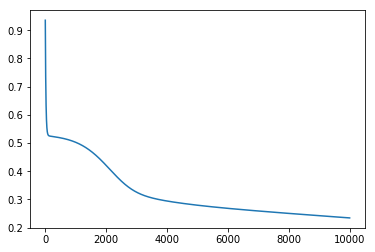

In [10]:
plt.plot(errors_GD)

In [11]:
def evaluate(test_data,test_labels,weight_list_new):
    cnt = 0
    for index,x in enumerate(test_data):
        x_n = np.empty((x.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = x
        x_l = feedforward(x_n,weight_list)[1]
        #print(x_l[-1][1])
        if x_l[-1][1] > 0 and test_labels[index] == 1:
            cnt += 1
        if x_l[-1][1] < 0 and test_labels[index] == -1:
            cnt += 1
    return cnt
cnt = evaluate(d_2_test_dataset,d_2_test_labels,weight_list_new_GD)

In [12]:
print(cnt)
print((cnt/len(d_2_test_dataset))*100)

485
97.0


In [13]:
print(errors_GD[-1])

0.23424529126856897


Text(0,0.5,'log10(Error)')

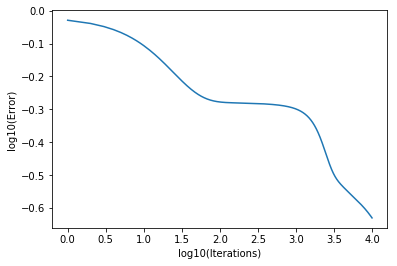

In [14]:
errors_GD = np.log10(errors_GD)
iters = np.log10([i for i in range(1,10001)])
plt.plot(iters,errors_GD)
plt.xlabel('log10(Iterations)')
plt.ylabel('log10(Error)')